In [53]:
import tensorflow as tf
import tensorflow_addons as tfa
import munkres
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
import math

In [40]:
def is_dense(x):
    return True if str(x)[37:].split(' ')[0]=='Dense' else False

#Hard Cost
def kost(dead_model, undead_model):
    neue=None
    worse_numerator, better_numerator, denominator=0, 0, 0
        
    for ij, (x, y)  in enumerate(zip(dead_model.layers, undead_model.layers)):
        print(f'Processed layer: {ij}')
        if is_dense(x):
            bx=x.weights[1]
            by=y.weights[1]
            x=x.weights[0]
            y=y.weights[0]
                        
            ln=x.shape[1]
            
            if neue is not None:
                x=neue
            worse_numerator+=tf.reduce_sum((x-y)*(x-y))+tf.reduce_sum((bx-by)*(bx-by))
            
            group_dead, group_undead=[], []
            cos_sim=tf.keras.losses.CosineSimilarity(-1)

            for i in range(ln):
                group_dead.append(tf.concat([x[:,i], [by[i]]], axis=0))
                group_undead.append(tf.concat([y[:,i], [by[i]]], axis=0))

            hungary=[]
            for i, d_el in enumerate(group_dead):
                hungary.append([])
                for j, u_el in enumerate(group_undead):
                    # Gdyby to faktycznie było cosine similarity, tu powinien być minus;
                    # Ale to nie jest cosine similarity, to jest -cosine similarity z tensorflowa jako f. kosztu
                    hungary[i].append(cos_sim(d_el, u_el).numpy())

            m = munkres.Munkres()
            indexes = m.compute(hungary)
            cols=[v for w, v in indexes]
            transformator_lefty=np.zeros(shape=(ln, ln), dtype='float32')
            transformator_righty=np.zeros(shape=(ln, ln), dtype='float32')
            for i, v in enumerate(cols):
                transformator_lefty[v,i]=1
                transformator_righty[i,v]=1

            eld=y@transformator_lefty
            post_eld=tf.einsum('j,jj->j', by, transformator_lefty)
            if (ij<len(dead_model.layers)-1):
                if ij<len(dead_model.layers)-1 and is_dense(dead_model.layers[ij+1]):
                    point=ij+1
                elif ij<len(dead_model.layers)-2 and is_dense(dead_model.layers[ij+2]):
                    point=ij+2
                elif ij<len(dead_model.layers)-3 and is_dense(dead_model.layers[ij+3]):
                    point=ij+3
                else:
                    point=None
                if point is not None:
                    neue=transformator_righty@undead_model.layers[point].weights[0]

            better_numerator+=tf.reduce_sum((x-eld)*(x-eld))+tf.reduce_sum((bx-post_eld)*(bx-post_eld))
            
            denominator+=(x.shape[0]*x.shape[1])+bx.shape[0]
            print (f'LOG normal:    {tf.reduce_sum((x-y)*(x-y))/(x.shape[0]*x.shape[1])}')
            print (f'LOG hungarian: {tf.reduce_sum((x-eld)*(x-eld))/(x.shape[0]*x.shape[1])}')
    return worse_numerator/denominator, worse_numerator/denominator

In [41]:
def model_generator1(weights=None, dropout_rate=0.0, bnorm=False, momentum=0.99):
    if weights!=None:
        init=[]
        init2=[]
        for i in range(5):
            init.append(tf.constant_initializer(weights[i][0].numpy()))
            init2.append(tf.constant_initializer(weights[i][1].numpy()))
        lst=[
            tf.keras.layers.Dense(50, activation="sigmoid", name="alpha", kernel_initializer=init[0], bias_initializer=init2[0]),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(100, activation="sigmoid", name="beta", kernel_initializer=init[1], bias_initializer=init2[1]),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(100, activation="relu", name="gamma", kernel_initializer=init[2], bias_initializer=init2[2]),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(100, activation="tanh", name="delta", kernel_initializer=init[3], bias_initializer=init2[3]),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(5, activation="sigmoid", name="epsilon", kernel_initializer=init[4], bias_initializer=init2[4]),
        ]
    else:
        lst=[
            tf.keras.layers.Dense(50, activation="sigmoid", name="alpha", bias_initializer=tf.random.normal),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(100, activation="sigmoid", name="beta", bias_initializer=tf.random.normal),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(100, activation="relu", name="gamma", bias_initializer=tf.random.normal),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(100, activation="tanh", name="delta", bias_initializer=tf.random.normal),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(5, activation="sigmoid", name="epsilon", bias_initializer=tf.random.normal),
        ]
        
    if bnorm==True:
        for i in range(len(lst)//2):
            lst.insert(i*3+1, tf.keras.layers.BatchNormalization(momentum=momentum))
    
    return tf.keras.Sequential(lst)

In [46]:
def generate_system(inputs, instances):
    return tf.random.normal((instances, inputs))

def testo(eval_set, ideal_y, neural):
    predicted_y=neural(eval_set)
    optim=tf.keras.losses.MeanSquaredError()
    return optim(predicted_y, ideal_y)

def generate_all_models(sol_type, weights, training_x, test_x, weight_decay=None, batch_size=32, **kwargs):
    ideal = model_generator1(weights, **kwargs)
    training_y, test_y=ideal(training_x), ideal(test_x)
    epochs=3
    results={}
    
    if weight_decay is not None:
        optimizers=[['sgdw', tf.keras.optimizers.SGD(weight_decay)], ['adamw', tfa.optimizers.AdamW(weight_decay)]]
    else:
        optimizers=[['sgd', tf.keras.optimizers.SGD()], ['adam', tf.keras.optimizers.Adam()], ['adamw', tfa.optimizers.AdamW(0.0001)]]
    
    for opt in optimizers:
        imperfect = model_generator1(**kwargs)
        imperfect.compile(optimizer=opt[1], loss='mse')
        imperfect.fit(training_x.numpy(), training_y.numpy(), epochs=epochs, batch_size=batch_size)
        results_train = testo(training_x, training_y, imperfect)
        results_test = testo(test_x, test_y, imperfect)
        print(f"TRAINO {opt[0]}: {results_train}")
        print(f"TESTO {opt[0]}:  {results_test}")
        
        post_fact=[kwargs[v] for v in kwargs]
        print(post_fact, [opt[0], weight_decay, batch_size])
        real_fact=[sol_type, opt[0], weight_decay, batch_size]
        real_fact.extend((post_fact))
        results[tuple(real_fact)]=(results_train, results_test, kost(ideal, imperfect))
    return results
    
significations=[]
for ij in range(1):
    train_instances_no, test_instances_no, inputs=50000, 10000, 10
    ideal = model_generator1()
    training_x, test_x = generate_system(inputs, train_instances_no), generate_system(inputs, test_instances_no)
    training_y, test_y = ideal(training_x), ideal(test_x)
    
    weights=[]
    for x in ideal.layers:
        if is_dense(x):
            weights.append(x.weights)
    signification={}
    for i in range(0, 6):
        print(f'Dropout eval, rate {i/10}')
        signification={**signification, **generate_all_models('dropout', weights, training_x, test_x, dropout_rate=i/10)}

    for i in range(2, 9, 2):
        for j in [0.1, 0.5, 0.9, 0.95, 0.99, 0.999]:
            print(f'Dropout eval, momentum {j}, batch_size {2**i}')
            signification={**signification, **generate_all_models('batch_norm', weights, training_x, test_x, batch_size=2**i, bnorm=True, momentum=j)}

    dissolution=[0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    for i in dissolution:
        signification={**signification, **generate_all_models('weight_decay', weights, training_x, test_x, weight_decay=i)}
    significations.append(signification)

Dropout eval, rate 0.0
Epoch 1/3
1563/1563 [==============================] - 1s 830us/step - loss: 0.0033
Epoch 2/3
1563/1563 [==============================] - 1s 853us/step - loss: 1.5755e-05
Epoch 3/3
1563/1563 [==============================] - 1s 849us/step - loss: 1.2095e-05
TRAINO sgd: 1.1871597962453961e-05
TESTO sgd:  1.1903882295882795e-05
[0.0] ['sgd', None, 32]
Processed layer: 0
LOG normal:    0.06997419148683548
LOG hungarian: 0.03484935685992241
Processed layer: 1
Processed layer: 2
LOG normal:    0.024454990401864052
LOG hungarian: 0.019821658730506897
Processed layer: 3
Processed layer: 4
LOG normal:    0.016428418457508087
LOG hungarian: 0.01570212095975876
Processed layer: 5
Processed layer: 6
LOG normal:    0.009607398882508278
LOG hungarian: 0.009607398882508278
Processed layer: 7
Processed layer: 8
LOG normal:    0.0
LOG hungarian: 0.0
Epoch 1/3
1563/1563 [==============================] - 1s 885us/step - loss: 1.5185e-04
Epoch 2/3
1563/1563 [====================

LOG normal:    0.06244906038045883
LOG hungarian: 0.03343334048986435
Processed layer: 1
Processed layer: 2
LOG normal:    0.023725800216197968
LOG hungarian: 0.019144749268889427
Processed layer: 3
Processed layer: 4
LOG normal:    0.016785545274615288
LOG hungarian: 0.015914052724838257
Processed layer: 5
Processed layer: 6
LOG normal:    0.010540911927819252
LOG hungarian: 0.010540911927819252
Processed layer: 7
Processed layer: 8
LOG normal:    0.0
LOG hungarian: 0.0
Epoch 1/3
1563/1563 [==============================] - 1s 862us/step - loss: 0.0031
Epoch 2/3
1563/1563 [==============================] - 1s 890us/step - loss: 1.9149e-04
Epoch 3/3
1563/1563 [==============================] - 1s 869us/step - loss: 8.3108e-05
TRAINO adam: 2.9465099942171946e-05
TESTO adam:  2.9328644814086147e-05
[0.3] ['adam', None, 32]
Processed layer: 0
LOG normal:    0.05941442772746086
LOG hungarian: 0.03273104131221771
Processed layer: 1
Processed layer: 2
LOG normal:    0.02252480946481228
LOG h

12500/12500 [==============================] - 11s 913us/step - loss: 0.0018
Epoch 2/3
12500/12500 [==============================] - 11s 918us/step - loss: 8.3225e-06
Epoch 3/3
12500/12500 [==============================] - 12s 920us/step - loss: 5.1068e-06
TRAINO adam: 0.001009452505968511
TESTO adam:  0.0010331548983231187
[True, 0.1] ['adam', None, 4]
Processed layer: 0
LOG normal:    0.0658220574259758
LOG hungarian: 0.04312308132648468
Processed layer: 1
Processed layer: 2
Processed layer: 3
LOG normal:    0.032193876802921295
LOG hungarian: 0.028790881857275963
Processed layer: 4
Processed layer: 5
Processed layer: 6
LOG normal:    0.01460456196218729
LOG hungarian: 0.01460456196218729
Processed layer: 7
Processed layer: 8
Processed layer: 9
LOG normal:    0.0
LOG hungarian: 0.0
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.0
LOG hungarian: 0.0
Epoch 1/3
12500/12500 [==============================] - 12s 933us/step - loss: 9.0455e-04
Epoch 2/3
1250

LOG normal:    0.06653953343629837
LOG hungarian: 0.037001267075538635
Processed layer: 1
Processed layer: 2
Processed layer: 3
LOG normal:    0.023530825972557068
LOG hungarian: 0.019103500992059708
Processed layer: 4
Processed layer: 5
Processed layer: 6
LOG normal:    0.01595039665699005
LOG hungarian: 0.015307966619729996
Processed layer: 7
Processed layer: 8
Processed layer: 9
LOG normal:    0.009024384431540966
LOG hungarian: 0.009024384431540966
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.0
LOG hungarian: 0.0
Epoch 1/3
12500/12500 [==============================] - 11s 903us/step - loss: 0.0014
Epoch 2/3
12500/12500 [==============================] - 11s 906us/step - loss: 9.5801e-06
Epoch 3/3
12500/12500 [==============================] - 11s 905us/step - loss: 5.9581e-06
TRAINO adam: 5.561169473367045e-06
TESTO adam:  5.789469923911383e-06
[True, 0.95] ['adam', None, 4]
Processed layer: 0
LOG normal:    0.07540617138147354
LOG hungarian: 0.0420

LOG normal:    0.00018765042477753013
LOG hungarian: 0.00013400007446762174
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.06353675574064255
LOG hungarian: 0.028738465160131454
Dropout eval, momentum 0.1, batch_size 16
Epoch 1/3
3125/3125 [==============================] - 3s 849us/step - loss: 0.0702
Epoch 2/3
3125/3125 [==============================] - 3s 941us/step - loss: 0.0175
Epoch 3/3
3125/3125 [==============================] - 3s 940us/step - loss: 0.0099
TRAINO sgd: 0.02002045139670372
TESTO sgd:  0.01988338865339756
[True, 0.1] ['sgd', None, 16]
Processed layer: 0
LOG normal:    0.06669552624225616
LOG hungarian: 0.03399987146258354
Processed layer: 1
Processed layer: 2
Processed layer: 3
LOG normal:    0.024632319808006287
LOG hungarian: 0.01948305033147335
Processed layer: 4
Processed layer: 5
Processed layer: 6
LOG normal:    0.01749376766383648
LOG hungarian: 0.0159719530493021
Processed layer: 7
Processed layer: 8
Processed layer: 9
LOG n

LOG normal:    0.03887508437037468
LOG hungarian: 0.025235988199710846
Processed layer: 1
Processed layer: 2
Processed layer: 3
LOG normal:    0.003993514459580183
LOG hungarian: 0.0031417703721672297
Processed layer: 4
Processed layer: 5
Processed layer: 6
LOG normal:    0.0027173664420843124
LOG hungarian: 0.0024788856972008944
Processed layer: 7
Processed layer: 8
Processed layer: 9
LOG normal:    0.002331780968233943
LOG hungarian: 0.0023111312184482813
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.0008874363848008215
LOG hungarian: 0.0008874363848008215
Dropout eval, momentum 0.95, batch_size 16
Epoch 1/3
3125/3125 [==============================] - 3s 901us/step - loss: 0.0279
Epoch 2/3
3125/3125 [==============================] - 3s 921us/step - loss: 0.0090
Epoch 3/3
3125/3125 [==============================] - 3s 908us/step - loss: 0.0056
TRAINO sgd: 0.00715910829603672
TESTO sgd:  0.007113052532076836
[True, 0.95] ['sgd', None, 16]
Processed lay

3125/3125 [==============================] - 3s 1ms/step - loss: 0.0013
Epoch 2/3
3125/3125 [==============================] - 3s 1ms/step - loss: 5.6026e-06
Epoch 3/3
3125/3125 [==============================] - 3s 1ms/step - loss: 2.1868e-06
TRAINO adamw: 3.461469532339834e-05
TESTO adamw:  3.4815202525351197e-05
[True, 0.999] ['adamw', None, 16]
Processed layer: 0
LOG normal:    0.036653466522693634
LOG hungarian: 0.025481918826699257
Processed layer: 1
Processed layer: 2
Processed layer: 3
LOG normal:    0.0038913863245397806
LOG hungarian: 0.0030701947398483753
Processed layer: 4
Processed layer: 5
Processed layer: 6
LOG normal:    0.0029834515880793333
LOG hungarian: 0.002529572229832411
Processed layer: 7
Processed layer: 8
Processed layer: 9
LOG normal:    0.002722244942560792
LOG hungarian: 0.0023933390621095896
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.006339655723422766
LOG hungarian: 0.006339655723422766
Dropout eval, momentum 0.1, batch_s

LOG normal:    0.019213419407606125
LOG hungarian: 0.01691470667719841
Processed layer: 7
Processed layer: 8
Processed layer: 9
LOG normal:    0.015032648108899593
LOG hungarian: 0.014589419588446617
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.012819650582969189
LOG hungarian: 0.012819650582969189
Epoch 1/3
782/782 [==============================] - 1s 2ms/step - loss: 0.0079
Epoch 2/3
782/782 [==============================] - 1s 2ms/step - loss: 9.4398e-05
Epoch 3/3
782/782 [==============================] - 1s 2ms/step - loss: 3.0938e-05
TRAINO adamw: 1.957966378540732e-05
TESTO adamw:  1.936386979650706e-05
[True, 0.9] ['adamw', None, 64]
Processed layer: 0
LOG normal:    0.05186016857624054
LOG hungarian: 0.029572997242212296
Processed layer: 1
Processed layer: 2
Processed layer: 3
LOG normal:    0.014803576283156872
LOG hungarian: 0.012224615551531315
Processed layer: 4
Processed layer: 5
Processed layer: 6
LOG normal:    0.010026836767792702
LOG 

196/196 [==============================] - 1s 3ms/step - loss: 0.0203
Epoch 2/3
196/196 [==============================] - 1s 3ms/step - loss: 9.2907e-04
Epoch 3/3
196/196 [==============================] - 1s 3ms/step - loss: 2.8722e-04
TRAINO adam: 0.0001684643211774528
TESTO adam:  0.0001740050793159753
[True, 0.9] ['adam', None, 256]
Processed layer: 0
LOG normal:    0.06500740349292755
LOG hungarian: 0.032767996191978455
Processed layer: 1
Processed layer: 2
Processed layer: 3
LOG normal:    0.025864293798804283
LOG hungarian: 0.01942083053290844
Processed layer: 4
Processed layer: 5
Processed layer: 6
LOG normal:    0.01925850287079811
LOG hungarian: 0.01651665009558201
Processed layer: 7
Processed layer: 8
Processed layer: 9
LOG normal:    0.01645429991185665
LOG hungarian: 0.01507596392184496
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.028180286288261414
LOG hungarian: 0.028180286288261414
Epoch 1/3
196/196 [==============================] - 1s 

LOG normal:    0.014794796705245972
LOG hungarian: 0.014645848423242569
Processed layer: 7
Processed layer: 8
Processed layer: 9
LOG normal:    0.0024875944945961237
LOG hungarian: 0.0024875944945961237
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.0
LOG hungarian: 0.0
Epoch 1/3
196/196 [==============================] - 1s 3ms/step - loss: 0.0199
Epoch 2/3
196/196 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 3/3
196/196 [==============================] - 1s 3ms/step - loss: 3.5216e-04
TRAINO adam: 0.017328495159745216
TESTO adam:  0.01732657290995121
[True, 0.999] ['adam', None, 256]
Processed layer: 0
LOG normal:    0.06263897567987442
LOG hungarian: 0.037917982786893845
Processed layer: 1
Processed layer: 2
Processed layer: 3
LOG normal:    0.023495923727750778
LOG hungarian: 0.01942852884531021
Processed layer: 4
Processed layer: 5
Processed layer: 6
LOG normal:    0.017421742901206017
LOG hungarian: 0.016267890110611916
Process

In [47]:
results={}
for x in significations[0]:
    title=x[0] # Nazwa tuningu
    subtitle=x[1] # Nazwa grada
    if (title=='weight_decay'):
        value=x[2]
    if (title=='dropout'):
        value=x[4]
    if (title=='batch_norm'):
        value=x[3], x[5]
    
    if title not in results:
        results[title]={}
        
    if subtitle in results[title]:
        results[title][subtitle][title].append(value)
        results[title][subtitle]['train_y'].append(signification[x][0].numpy())
        results[title][subtitle]['test_y'].append(signification[x][1].numpy())
        results[title][subtitle]['w'].append(signification[x][2][1].numpy())
    else:
        results[title][subtitle]={}
        results[title][subtitle][title]=[value]
        results[title][subtitle]['train_y']=[signification[x][0].numpy()]
        results[title][subtitle]['test_y']=[signification[x][1].numpy()]
        results[title][subtitle]['w']=[signification[x][2][1].numpy()]
        
#print(results)

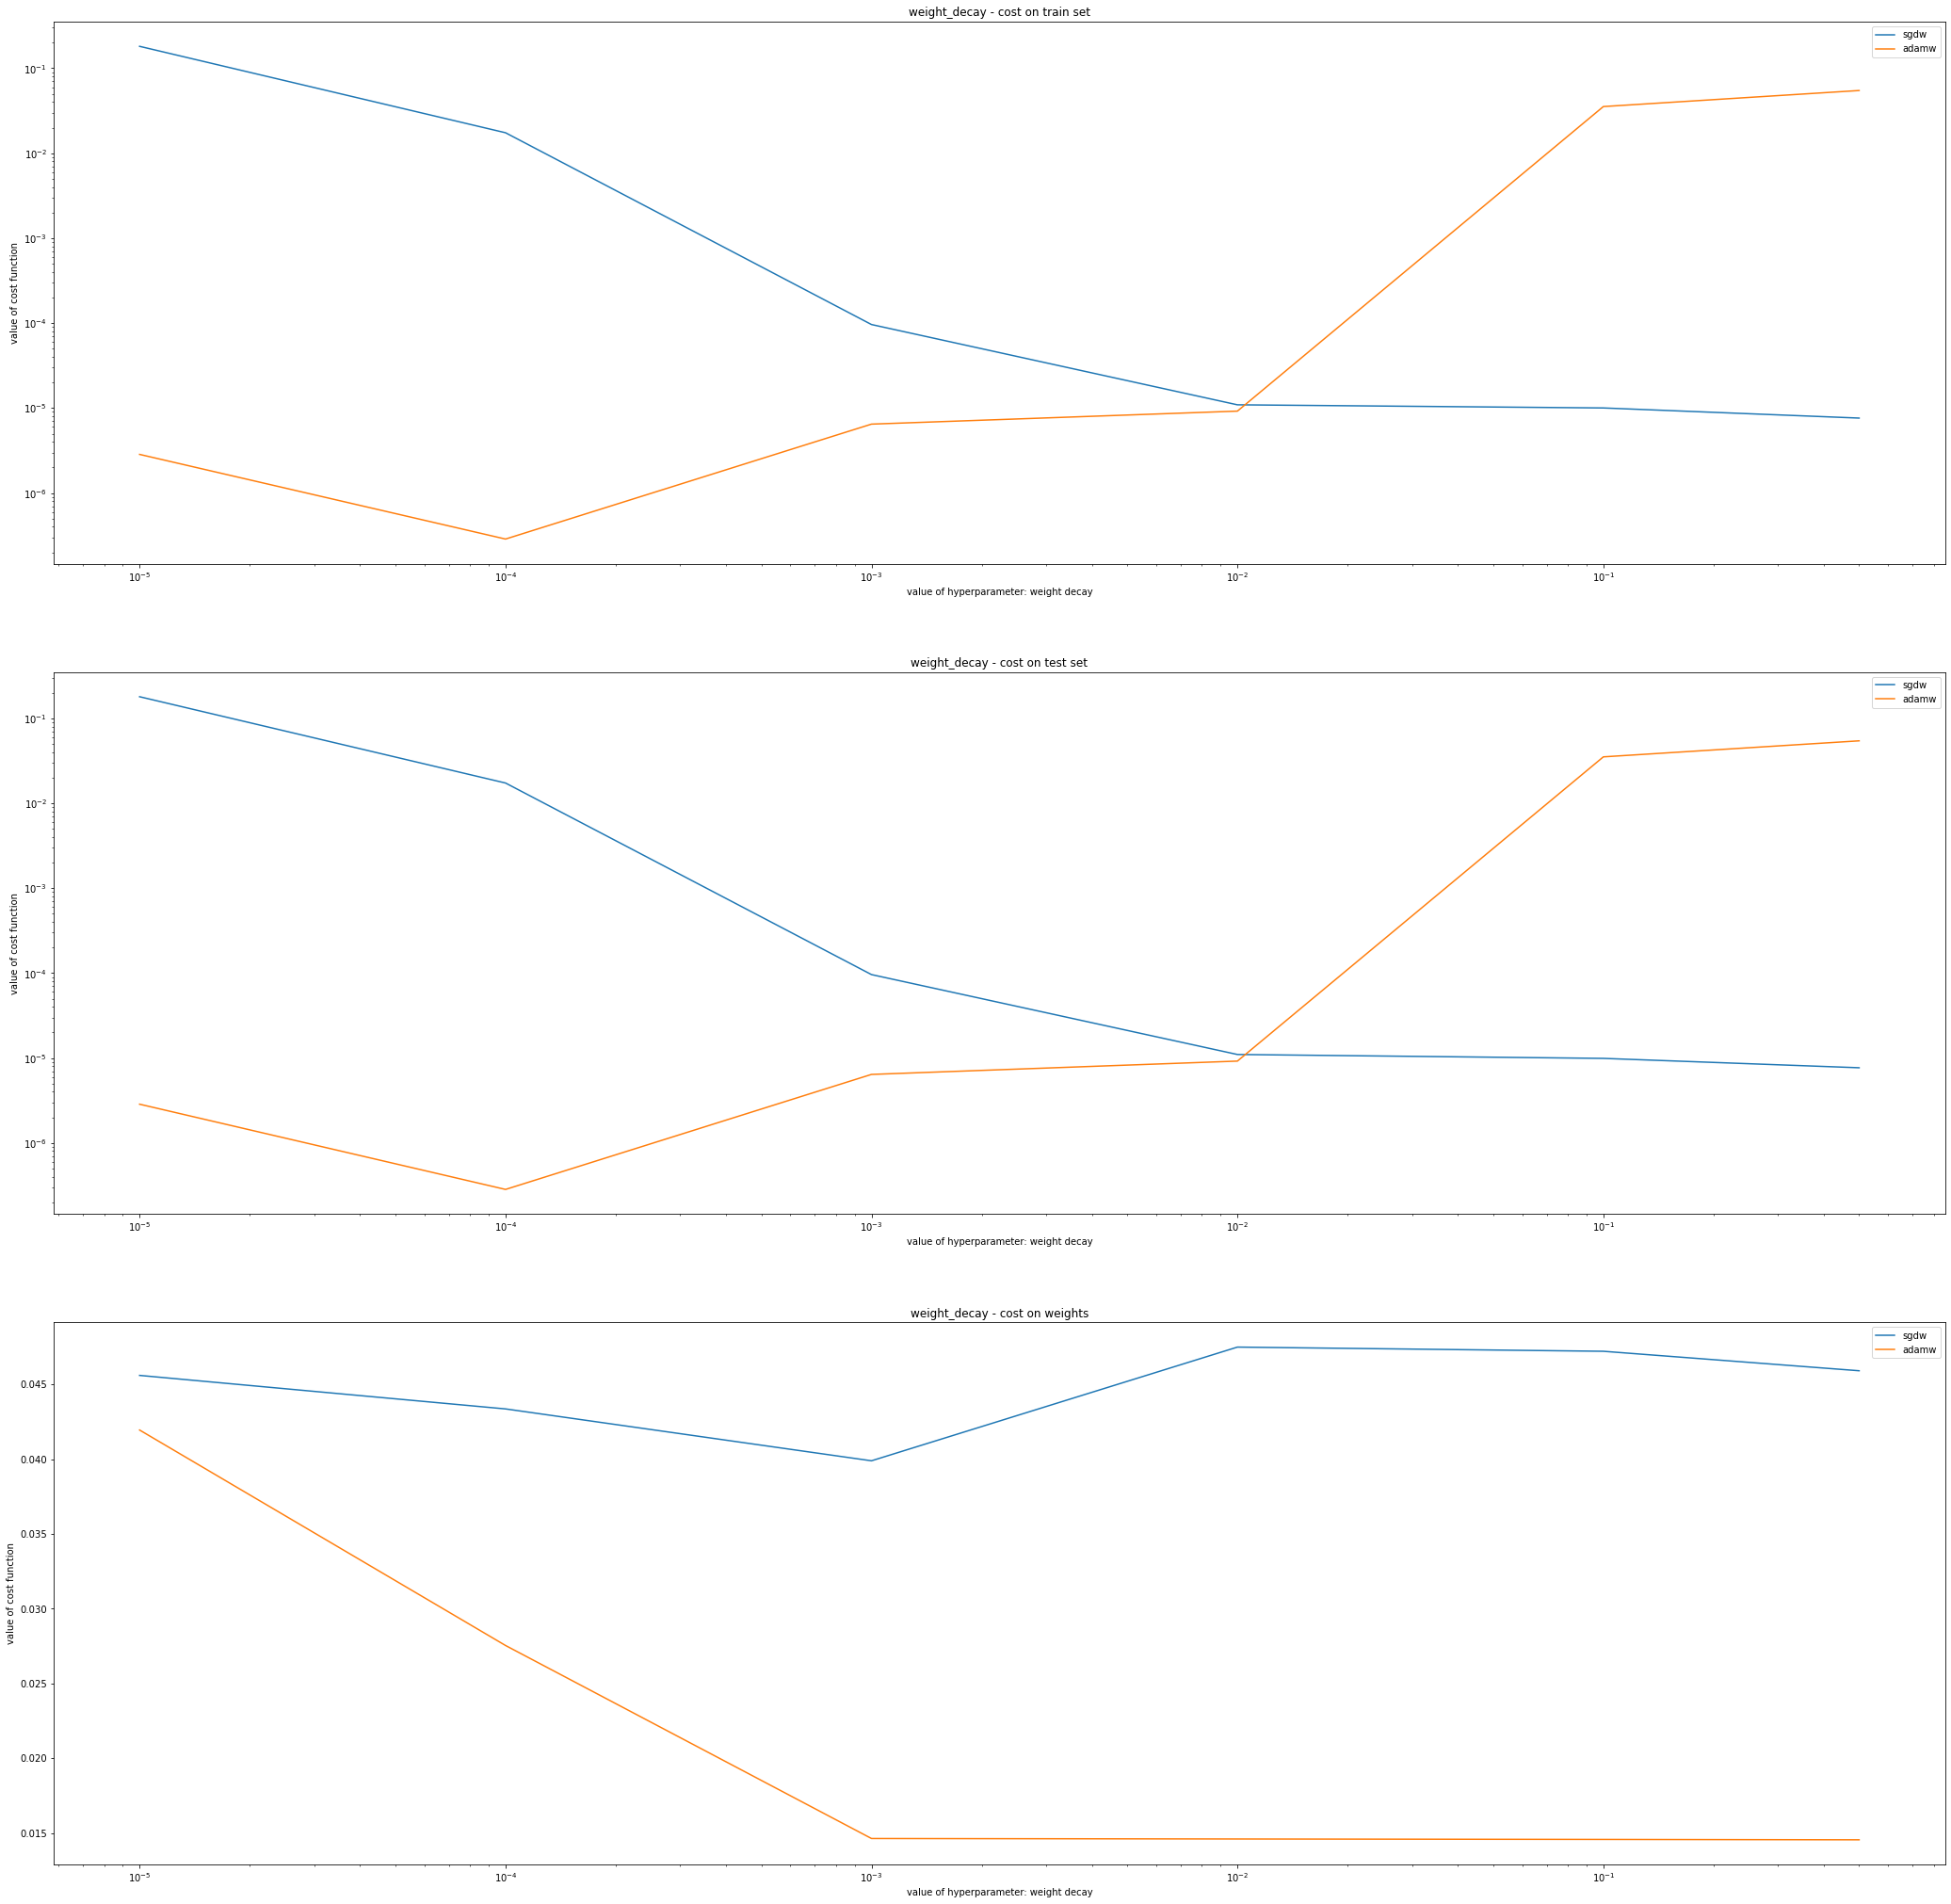

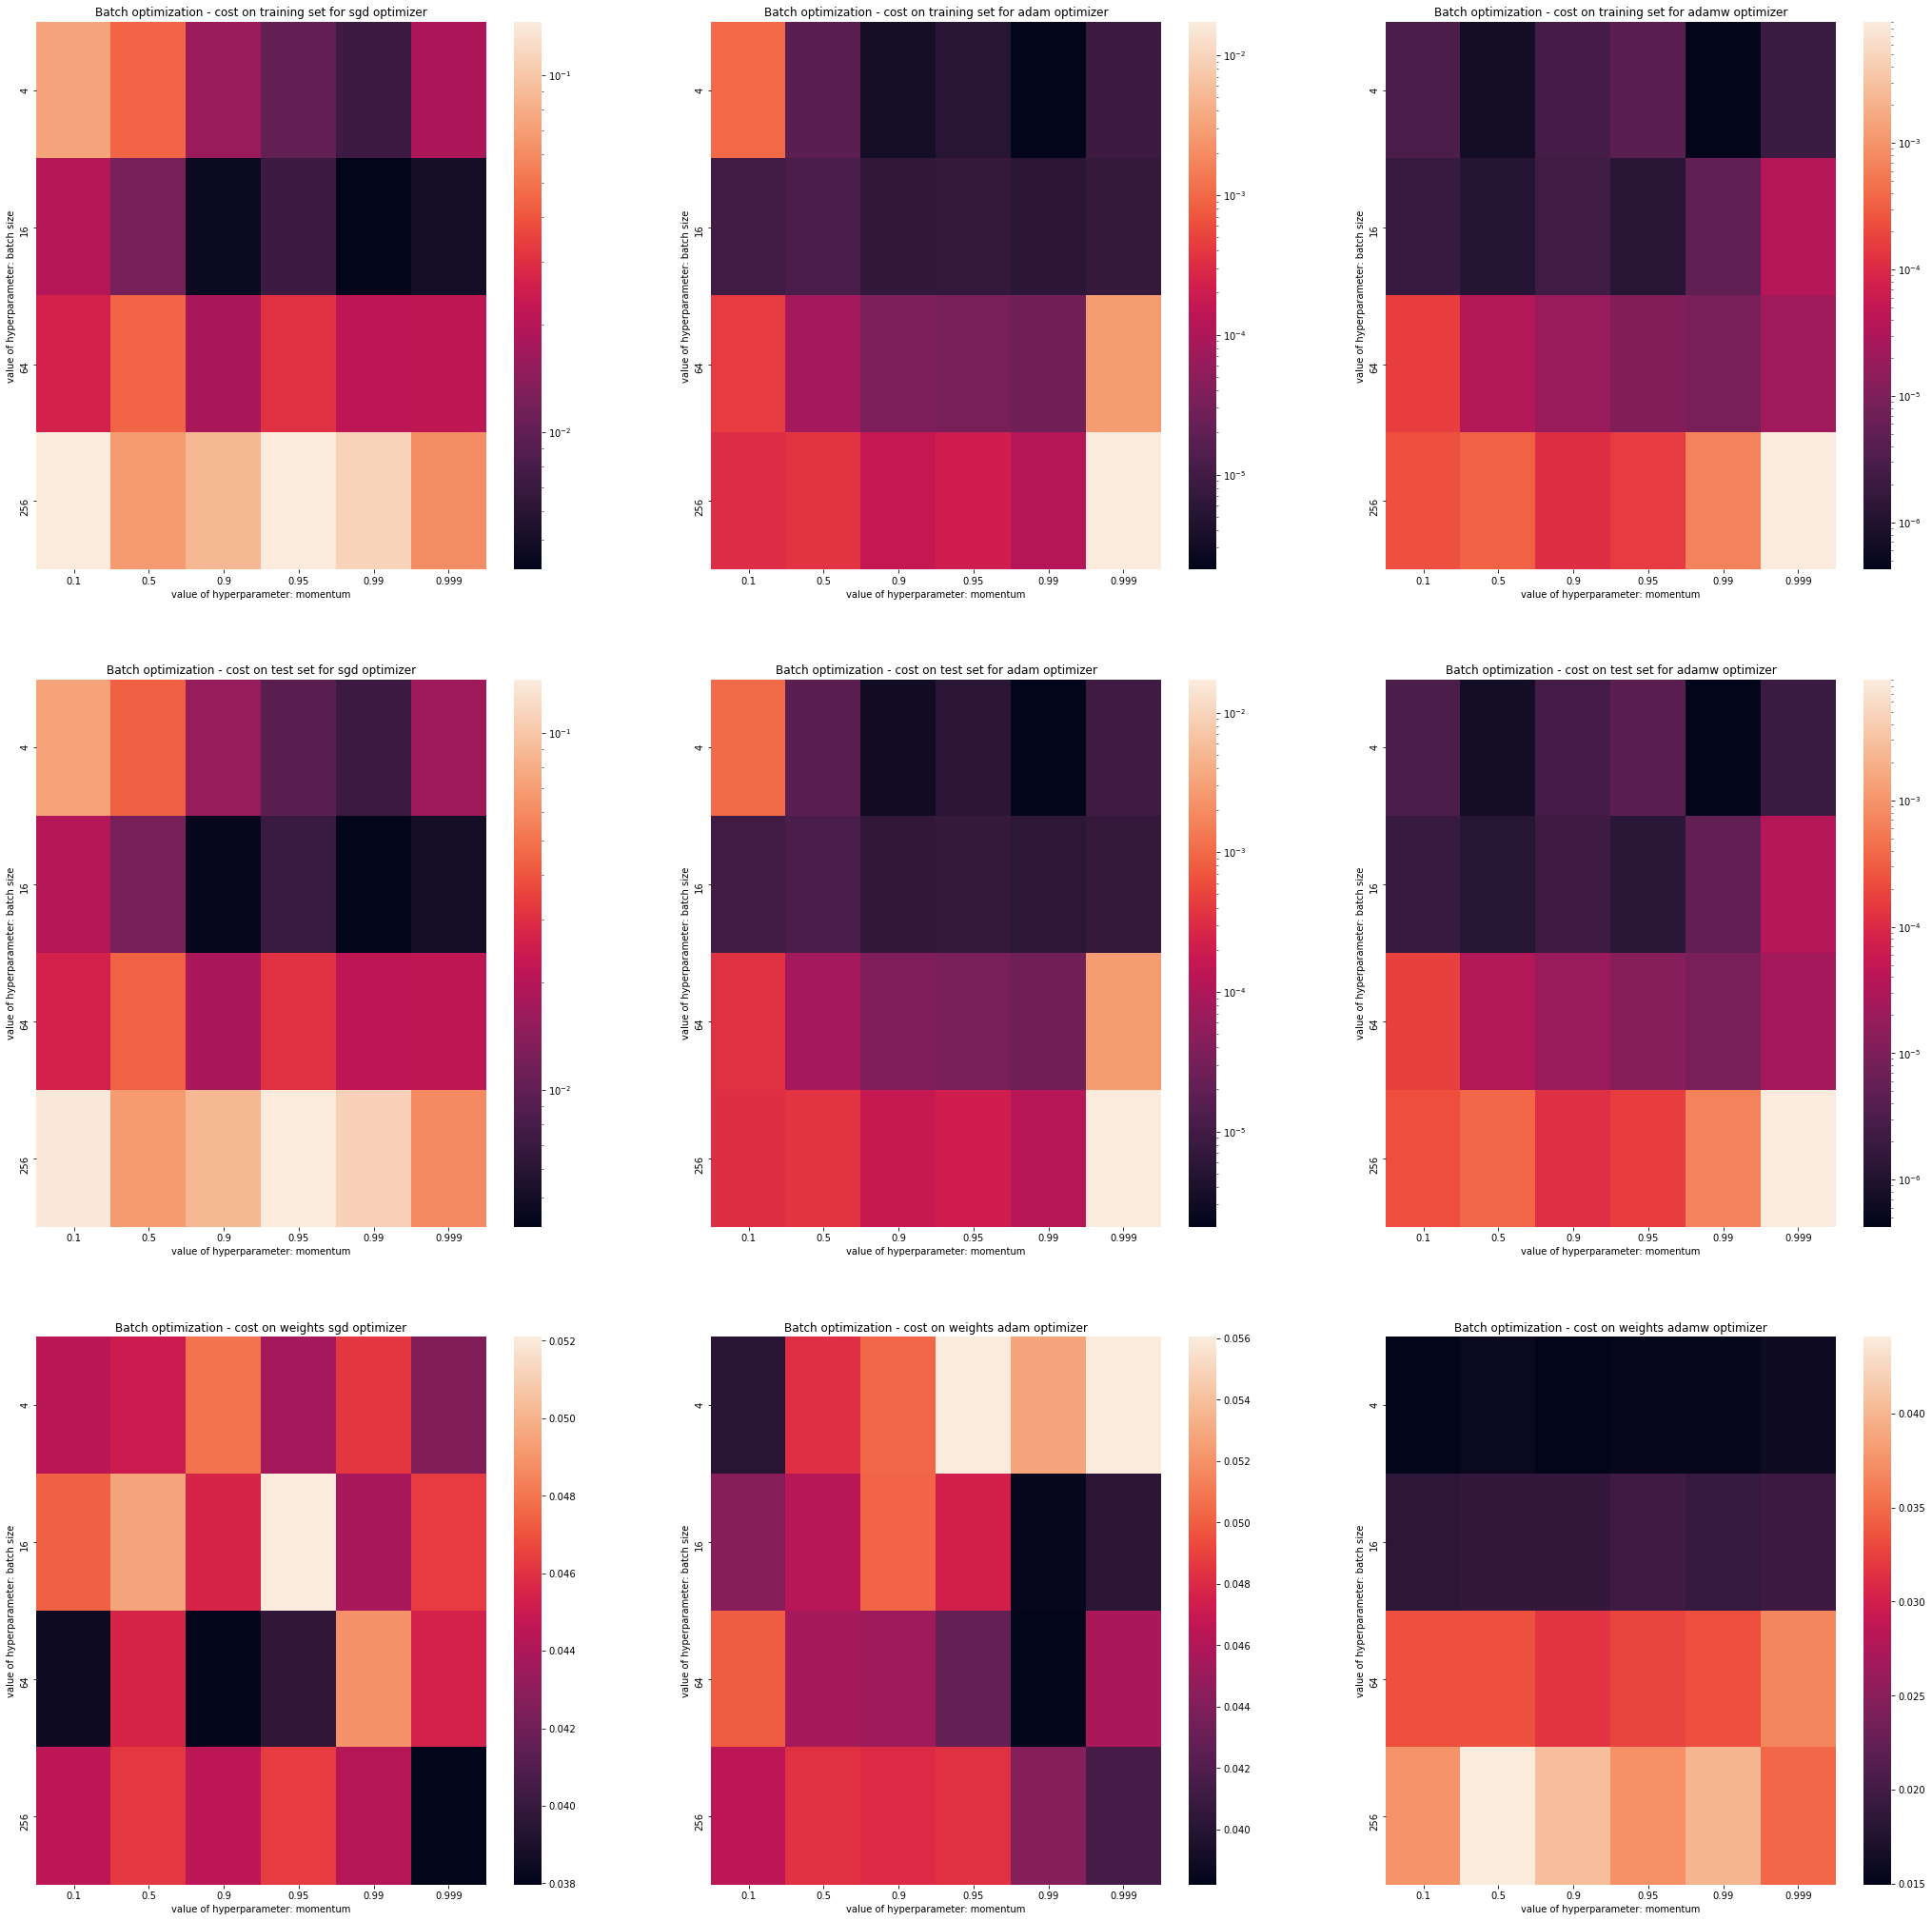

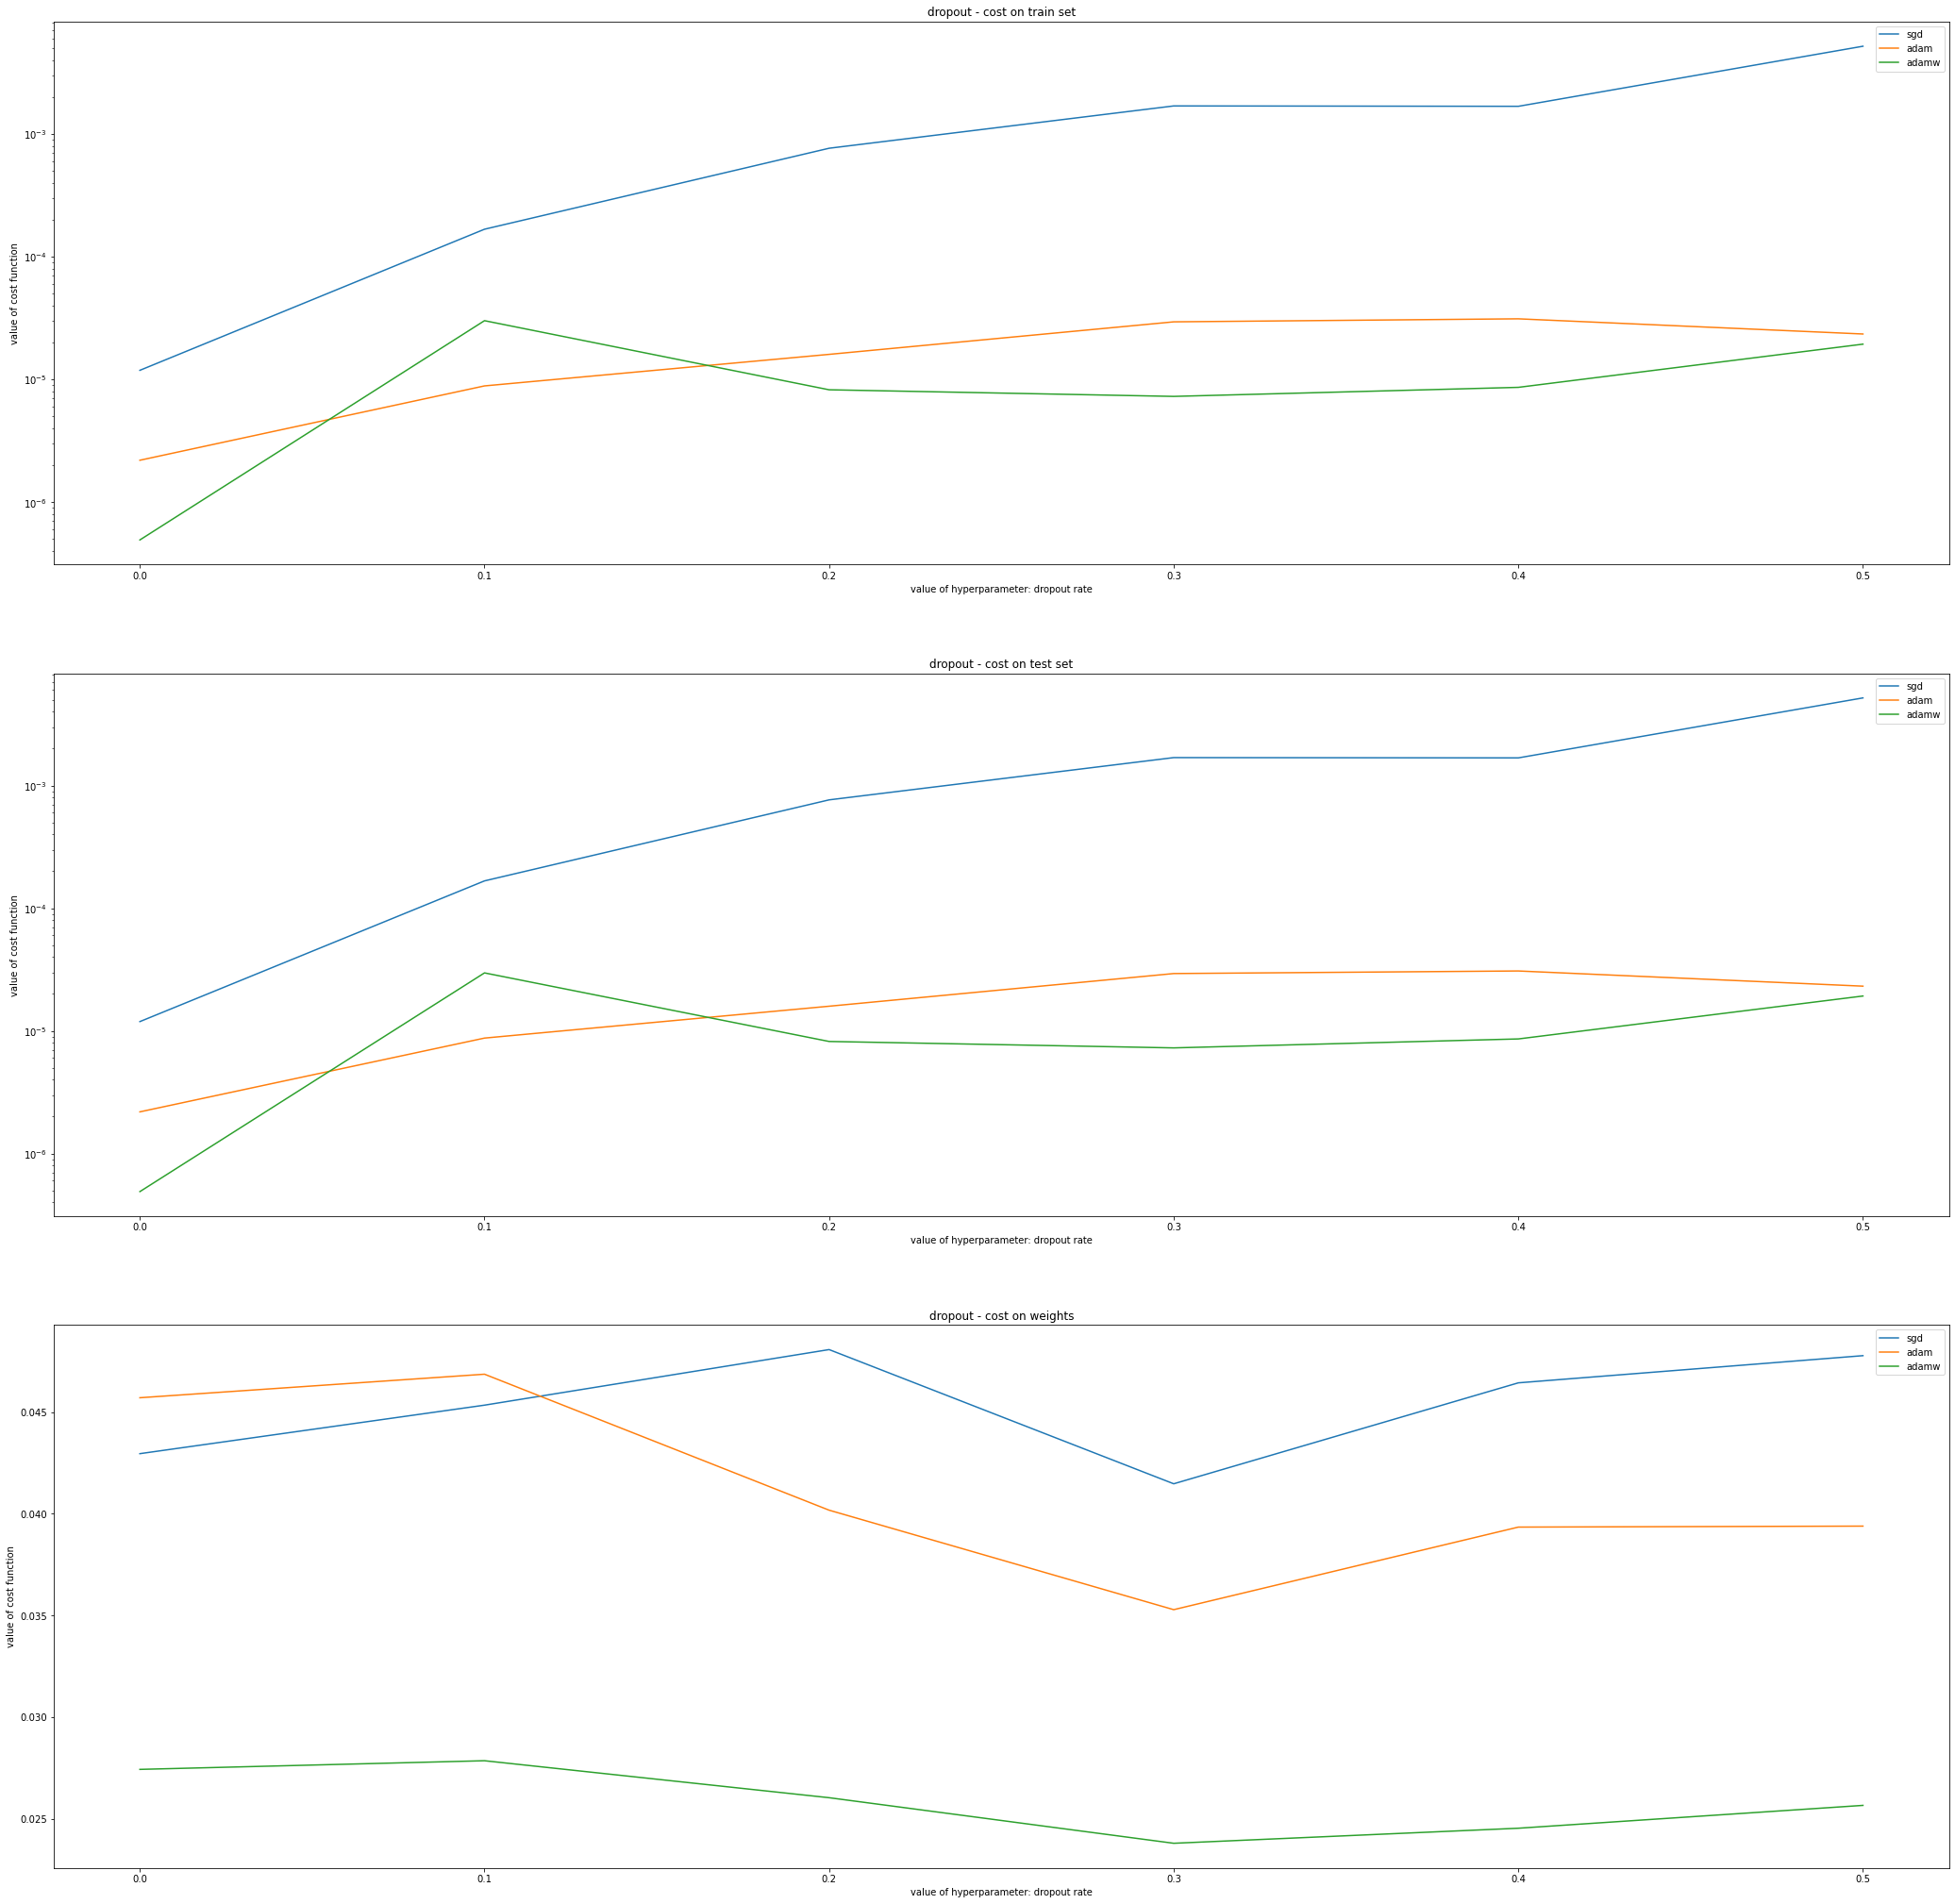

In [68]:
for y in ['weight_decay', 'batch_norm', 'dropout']:
    if (y!='batch_norm'):
        fig, ax=plt.subplots(3, 1, figsize=(36, 36))
        if y!='dropout':
            for i in range(3):
                ax[i].set_xscale('log')
        for i in range(2):
            ax[i].set_yscale('log')
        
        for x in results[y]:
            ax[0].plot(results[y][x][y], results[y][x]['train_y'], label=x)
            ax[1].plot(results[y][x][y], results[y][x]['test_y'], label=x)
            ax[2].plot(results[y][x][y], results[y][x]['w'], label=x)
            ax[0].set_title(f'{y} - cost on train set')        
            ax[1].set_title(f'{y} - cost on test set')
            ax[2].set_title(f'{y} - cost on weights')

        for i in range(3):
            ax[i].legend()
            ax[i].set_xlabel(f'value of hyperparameter: {"weight decay" if y=="weight_decay" else "dropout rate"}')
            ax[i].set_ylabel('value of cost function')
            
    else:
        fig, ax=plt.subplots(3, 3, figsize=(36, 36))
        for ij, x in enumerate(results[y]):
            dct1, dct2={}, {}
            data=results[y][x][y]
            num=0
            for f1, f2 in data:
                if f1 not in dct1:
                    dct1[f1]=num
                    num+=1
            num=0
            for f1, f2 in data:
                if f2 not in dct2:
                    dct2[f2]=num
                    num+=1
            c_train_y=np.zeros((len(dct1), len(dct2)), dtype='float32')
            c_test_y=np.zeros((len(dct1), len(dct2)), dtype='float32')
            c_w=np.zeros((len(dct1), len(dct2)), dtype='float32')
            for f1, f2 in data:
                c_train_y[dct1[f1],dct2[f2]]=[w for w, key in zip(results[y][x]['train_y'], results[y][x][y]) if key==(f1, f2)][0]
                c_test_y[dct1[f1],dct2[f2]]=[w for w, key in zip(results[y][x]['test_y'], results[y][x][y]) if key==(f1, f2)][0]
                c_w[dct1[f1],dct2[f2]]=[w for w, key in zip(results[y][x]['w'], results[y][x][y]) if key==(f1, f2)][0]
            
            sns.heatmap(c_train_y, ax=ax[0][ij], norm=matplotlib.colors.LogNorm())
            sns.heatmap(c_test_y, ax=ax[1][ij], norm=matplotlib.colors.LogNorm())
            sns.heatmap(c_w, ax=ax[2][ij])
            ax[0][ij].set_title(f'Batch optimization - cost on training set for {x} optimizer')
            ax[1][ij].set_title(f'Batch optimization - cost on test set for {x} optimizer')
            ax[2][ij].set_title(f'Batch optimization - cost on weights {x} optimizer')
        for i in range(3):
            for j in range(3):                       
                ax[i][j].set_ylabel('value of hyperparameter: batch size')
                ax[i][j].set_xlabel('value of hyperparameter: momentum')
                ax[i][j].set_yticklabels([z for z in dct1])
                ax[i][j].set_xticklabels([z for z in dct2])
            
            
    plt.show()
    fig.savefig(f'Comparision_{y}.png')

In [7]:
tf.__version__
#print(model.layers[1].bias.numpy())
#print(model.layers[1].weights)
#print(outer)

'2.3.0'

In [67]:
#post_system=signification.copy()
print(post_system)

{('dropout', 'sgd', None, 32, 0.0): (<tf.Tensor: shape=(), dtype=float32, numpy=1.1871598e-05>, <tf.Tensor: shape=(), dtype=float32, numpy=1.1903882e-05>, (<tf.Tensor: shape=(), dtype=float32, numpy=0.04295806>, <tf.Tensor: shape=(), dtype=float32, numpy=0.04295806>)), ('dropout', 'adam', None, 32, 0.0): (<tf.Tensor: shape=(), dtype=float32, numpy=2.196863e-06>, <tf.Tensor: shape=(), dtype=float32, numpy=2.1871592e-06>, (<tf.Tensor: shape=(), dtype=float32, numpy=0.04570733>, <tf.Tensor: shape=(), dtype=float32, numpy=0.04570733>)), ('dropout', 'adamw', None, 32, 0.0): (<tf.Tensor: shape=(), dtype=float32, numpy=4.927325e-07>, <tf.Tensor: shape=(), dtype=float32, numpy=4.895053e-07>, (<tf.Tensor: shape=(), dtype=float32, numpy=0.027435124>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027435124>)), ('dropout', 'sgd', None, 32, 0.1): (<tf.Tensor: shape=(), dtype=float32, numpy=0.00016742146>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00016698985>, (<tf.Tensor: shape=(), dtype=float32

In [4]:
#Hard Cost
def kost(dead_model, undead_model):
    neue=None
    worse_numerator, better_numerator, denominator=0, 0, 0
        
    for ij, (x, y)  in enumerate(zip(dead_model.layers, undead_model.layers)):
        print(f'Processed layer: {ij}')
        if is_dense(x):
            bx=x.weights[1]
            by=y.weights[1]
            x=x.weights[0]
            y=y.weights[0]
                        
            ln=x.shape[1]
            
            if neue is not None:
                x=neue
            worse_numerator+=tf.reduce_sum((x-y)*(x-y))
            
            group_dead, group_undead=[], []
            cos_sim=tf.keras.losses.CosineSimilarity(-1)

            for i in range(ln):
                group_dead.append(tf.concat([x[:,i], [by[i]]], axis=0))
                group_undead.append(tf.concat([y[:,i], [by[i]]], axis=0))

            hungary=[]
            for i, d_el in enumerate(group_dead):
                hungary.append([])
                for j, u_el in enumerate(group_undead):
                    # Gdyby to faktycznie było cosine similarity, tu powinien być minus;
                    # Ale to nie jest cosine similarity, to jest -cosine similarity z tensorflowa jako f. kosztu
                    hungary[i].append(cos_sim(d_el, u_el).numpy())

            m = munkres.Munkres()
            indexes = m.compute(hungary)
            cols=[v for w, v in indexes]
            transformator_lefty=np.zeros(shape=(ln, ln), dtype='float32')
            transformator_righty=np.zeros(shape=(ln, ln), dtype='float32')
            for i, v in enumerate(cols):
                transformator_lefty[v,i]=1
                transformator_righty[i,v]=1

            eld=y@transformator_lefty
            post_eld=tf.einsum('j,jj->j', by, transformator_lefty)
            if (ij<len(dead_model.layers)-1):
                if ij<len(dead_model.layers)-1 and is_dense(dead_model.layers[ij+1]):
                    point=ij+1
                elif ij<len(dead_model.layers)-2 and is_dense(dead_model.layers[ij+2]):
                    point=ij+2
                elif ij<len(dead_model.layers)-3 and is_dense(dead_model.layers[ij+3]):
                    point=ij+3
                else:
                    point=None
                if point is not None:
                    neue=transformator_righty@undead_model.layers[point].weights[0]

            better_numerator+=tf.reduce_sum((x-eld)*(x-eld))+tf.reduce_sum((bx-post_eld)*(bx-post_eld))
            
            denominator+=(x.shape[0]*x.shape[1])+bx.shape[0]
            print (f'LOG normal:    {tf.reduce_sum((x-y)*(x-y))/(x.shape[0]*x.shape[1])}')
            print (f'LOG hungarian: {tf.reduce_sum((x-eld)*(x-eld))/(x.shape[0]*x.shape[1])}')
    return worse_numerator/denominator, worse_numerator/denominator


#Eazy Cost
def kost(dead_model, undead_model):
    neue=None
    worse_numerator, better_numerator, denominator=0, 0, 0
        
    for ij, (x, y)  in enumerate(zip(dead_model.layers, undead_model.layers)):
        print(f'Processed layer: {ij}')
        if is_dense(x):
            x=x.weights[0]
            y=y.weights[0]
            ln=x.shape[1]
            
            if neue is not None:
                x=neue
                
            worse_numerator+=tf.reduce_sum((x-y)*(x-y))
            denominator+=(x.shape[0]*x.shape[1])
            print (f'LOG normal:    {tf.reduce_sum((x-y)*(x-y))/(x.shape[0]*x.shape[1])}')
            #print (f'LOG hungarian: {tf.reduce_sum((x-eld)*(x-eld))/(x.shape[0]*x.shape[1])}')
    return worse_numerator/denominator, worse_numerator/denominator